In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk, messagebox

%matplotlib inline

In [2]:
class PortfolioOptimizer:
    def __init__(self, expected_return=[0.1934,0.1575], volatility=[0.3025,0.219], corr_matrix=[[1,0.35],[0.35,1]], risk_free_rate= 0.045, portfolio_size=2, risk_aversion=3):
        self.expected_return = expected_return
        self.risk_free_rate = risk_free_rate
        self.portfolio_size = portfolio_size
        self.risk_aversion = risk_aversion
        if (self.is_effectively_empty(expected_return) and self.is_effectively_empty(volatility) and self.is_effectively_empty(corr_matrix)):
            self.returns=np.asarray(expected_return)
            corr_matrix = np.array(corr_matrix)
            stdv = np.array(volatility)
            self.cov_matrix = np.outer(stdv, stdv) * corr_matrix
        else:
            self.ds = self.get_data(portfolio_size)
            self.returns = self.calculate_annualized_returns()
            self.cov_matrix = self.compute_covariance_matrix(self.ds)
            
        self.inv_cov_matrix = np.linalg.inv(self.cov_matrix)
        
    def is_effectively_empty(self,lst):
        if lst and len(lst)==self.portfolio_size:
            return True
        return False

    def get_data(self, n):
        ds = pd.read_excel('230023476PortfolioProblem.xlsx')
        ds['Date'] = pd.to_datetime(ds['Date'])
        ds.iloc[:, 1:] = ds.iloc[:, 1:].pct_change()
        return ds.iloc[:, :n + 1].dropna()

    def calculate_annualized_returns(self):
        returns = self.ds.iloc[:, 1:] # Exclude dates
        compounded_returns = (returns + 1).prod() ** (12 / len(returns)) - 1
        return compounded_returns.values

    def compute_covariance_matrix(self, dataset):
        cov_matrix = dataset.drop(columns=['Date']).cov() * 12
        return cov_matrix

    def calculate_intermediate_quantities(self):
        u = np.ones(self.portfolio_size)
        inv_cov_matrix = self.inv_cov_matrix
        A = np.sum([np.sum(u[i] * self.returns[j] * inv_cov_matrix[i, j] for i in range(self.portfolio_size)) for j in range(self.portfolio_size)])
        B = np.sum([np.sum(self.returns[i] * self.returns[j] * inv_cov_matrix[i, j] for i in range(self.portfolio_size)) for j in range(self.portfolio_size)])
        C = np.sum([np.sum(u[i] * u[j] * inv_cov_matrix[i, j] for i in range(self.portfolio_size)) for j in range(self.portfolio_size)])
        M = np.dot(np.ones(self.portfolio_size), self.inv_cov_matrix)
        L = self.returns @ inv_cov_matrix
        D = B * C - A ** 2
        LA = np.dot(L, A)
        MB = np.dot(M, B)
        
        G = (1/D) * (MB - LA)
        
        LB = L * C
        MA = M * A

        H = (LB - MA) / D
        
        return A, B, C, D, G, H
    
    def calculate_portfolio_metrics(self, weights):
        portfolio_return = np.sum(weights * self.returns)
        portfolio_variance = np.dot(weights.T, np.dot(self.cov_matrix, weights))
        portfolio_risk = np.sqrt(portfolio_variance)
        excess_return = portfolio_return - self.risk_free_rate
        sharpe_ratio = excess_return / portfolio_risk
        utility = portfolio_return - 0.5 * self.risk_aversion * portfolio_variance
        return portfolio_return, portfolio_risk, sharpe_ratio, utility

    def calculate_minimum_variance_portfolio(self):
        _, _, C, _, _, _ = self.calculate_intermediate_quantities()
        min_var_weights = np.dot(self.inv_cov_matrix, np.ones(self.portfolio_size)) / C
        return min_var_weights, self.calculate_portfolio_metrics(min_var_weights)

    def calculate_optimum_variance_portfolio(self, target_return):
        _, _, _, _, G, H = self.calculate_intermediate_quantities()
        weights = G+(target_return*H)
        return weights, self.calculate_portfolio_metrics(weights)

    def calculate_mean_variance_efficient_frontier(self):
        min_var_weights, _ = self.calculate_minimum_variance_portfolio()
        frontier_weights = []
        for target_return in np.linspace(0, 1, 101):
            opt_var_weights, _ = self.calculate_optimum_variance_portfolio(target_return)
            weights = (1 - target_return) * min_var_weights + target_return * opt_var_weights
            frontier_weights.append(weights)
        frontier_metrics = [self.calculate_portfolio_metrics(w) for w in frontier_weights]
        return frontier_weights, frontier_metrics

    def plot_efficient_frontier(self):
        _, frontier_metrics = self.calculate_mean_variance_efficient_frontier()
        frontier_risks = [metric[1] for metric in frontier_metrics]
        frontier_returns = [metric[0] for metric in frontier_metrics]
        sharpe_ratios = [metric[2] for metric in frontier_metrics]

        min_var_idx = np.argmin(frontier_risks)
        min_var_point = frontier_metrics[min_var_idx]
        
        max_sharpe_idx = np.argmax(sharpe_ratios)
        max_sharpe_point = frontier_metrics[max_sharpe_idx]

        plt.figure(figsize=(12, 8))

        plt.plot(frontier_risks, frontier_returns, 'b-o', label='Efficient Frontier')

        plt.scatter(min_var_point[1], min_var_point[0], color='green', marker='o', s=100, 
                zorder=5, label=f'Min Variance Stdv: {min_var_point[1]:.4f}')
    
        plt.scatter(max_sharpe_point[1], max_sharpe_point[0], color='red', marker='o', s=100, 
                    zorder=5, label=f'Max Sharpe Ratio: {max_sharpe_point[2]:.4f}')

        plt.annotate(f'Min Variance\nStdv: {min_var_point[1]:.4f}', 
                    xy=(min_var_point[1], min_var_point[0]), 
                    xytext=(min_var_point[1] + 0.03, min_var_point[0] + 0.03),
                    arrowprops=dict(facecolor='green', shrink=0.05),
                    verticalalignment='bottom', horizontalalignment='right', color='green', fontsize=10, fontweight='bold')

        plt.annotate(f'Max Sharpe Ratio\nSharpe: {max_sharpe_point[2]:.4f}', 
                    xy=(max_sharpe_point[1], max_sharpe_point[0]), 
                    xytext=(max_sharpe_point[1] - 0.15, max_sharpe_point[0] + 0.03),
                    arrowprops=dict(facecolor='red', shrink=0.05),
                    verticalalignment='bottom', horizontalalignment='right', color='red', fontsize=10, fontweight='bold')

        plt.xlabel('Portfolio Volatility (Risk)', fontsize=12, fontweight='bold')
        plt.ylabel('Portfolio Return', fontsize=12, fontweight='bold')
        plt.title('Mean-Variance Efficient Frontier', fontsize=14, fontweight='bold')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
        plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
        plt.xlim(0.0, max(frontier_risks))

        plt.show()

    def write_to_excel(self, output_file='230023476PortfolioProblem.xlsx'):
        frontier_weights, frontier_metrics = self.calculate_mean_variance_efficient_frontier()
        if hasattr(self, 'ds'):
            weight_columns = [f'w_{col}' for col in self.ds.columns[1:]]
        else:
            weight_columns = [f'w{i+1}' for i in range(self.portfolio_size)]
        data = {
            'Return': [metric[0] for metric in frontier_metrics],
            'Volatility': [metric[1] for metric in frontier_metrics],
            'Utility': [metric[3] for metric in frontier_metrics],
            'Sharpe Ratio': [metric[2] for metric in frontier_metrics]
        }

        for i, col in enumerate(weight_columns):
            data[col] = [w[i] for w in frontier_weights]

        df = pd.DataFrame(data)
        df.sort_values(by='Return', inplace=True)
        numeric_columns = ['Return', 'Volatility', 'Utility', 'Sharpe Ratio'] + weight_columns
        df[numeric_columns] = df[numeric_columns].round(4)
        
        
        with pd.ExcelWriter(output_file, mode='a', engine="openpyxl",if_sheet_exists="replace") as writer:
            df.to_excel(writer, sheet_name='output', index=False)
            workbook = writer.book
            worksheet = workbook['output']
            
            for column_cells in worksheet.columns:
                max_length = 0
                column = column_cells[0].column_letter
                for cell in column_cells:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(cell.value)
                    except:
                        pass
                adjusted_width = (max_length + 2) * 1.2
                worksheet.column_dimensions[column].width = adjusted_width
        
        return df
    
    def print_values(self, df):
        max_sharpe_idx = df['Sharpe Ratio'].idxmax()
        max_sharpe_return = df.loc[max_sharpe_idx, 'Return']
        max_sharpe_volatility = df.loc[max_sharpe_idx, 'Volatility']
        max_sharpe_value = df.loc[max_sharpe_idx, 'Sharpe Ratio']
        
        print(f"Maximum Sharpe Ratio Portfolio:")
        print(f"Return: {max_sharpe_return:.4f}, Volatility: {max_sharpe_volatility:.4f}, Sharpe Ratio: {max_sharpe_value:.4f}")
        
        print('\n' * 2)
        
        max_utility_idx = df['Utility'].idxmax()
        max_utility_return = df.loc[max_utility_idx, 'Return']
        max_utility_volatility = df.loc[max_utility_idx, 'Volatility']
        max_utility_value = df.loc[max_utility_idx, 'Utility']
        print(f"Maximum Utility Portfolio:")
        print(f"Return: {max_utility_return:.4f}, Volatility: {max_utility_volatility:.4f}, Utility: {max_utility_value:.4f}")
        
        print('\n' * 2)    
         
        min_volatility_idx = df['Volatility'].idxmin()
        min_volatility_return = df.loc[min_volatility_idx, 'Return']
        min_volatility_volatility = df.loc[min_volatility_idx, 'Volatility']
        
        print(f"Minimum Volatility Portfolio:")
        print(f"Return: {min_volatility_return:.4f}, Volatility: {min_volatility_volatility:.4f}")

        print('\n' * 2) 


In [3]:
# Using same data as the file "Excel mapped HL procedure"
def main():
    optimizer = PortfolioOptimizer()
    
    # Showing values generated in def calculate_intermediate_quantities()
    variable_names=["A", "B", "C", "D", "G", "H"]
    try:
        variable_values = optimizer.calculate_intermediate_quantities()
        print("{0:^5s}{1:<12s}{2:>4s}".format("No#", "Variable", "Result"))
        idx = 1
        for var_name, value in zip(variable_names, variable_values):
            if isinstance(value, np.ndarray):
                for sub_value in value:
                    print("{0:^5d}{1:<12s}{2:,.4f}".format(idx, var_name, sub_value))
                    idx += 1
            else:
                print("{0:^5d}{1:<12s}{2:,.4f}".format(idx, var_name, value))
                idx += 1

    except Exception as e:
        print(f"Error occurred when printing intermediate quantities: {e}")
        
    print('\n'*2)
    
    # Showig the 10 outputs of def calculate_mean_variance_efficient_frontier() --> remove 10 from the for loop to print all values.
    try:
        _, mean_var_portfolios = optimizer.calculate_mean_variance_efficient_frontier()
        
        # Print header
        print("{0:^15s}{1:^15s}{2:^15s}{3:^15s}{4:^15s}".format("Target return", "Return", "Volatility", "Sharpe Ratio", "Utility"))

        if mean_var_portfolios:
            for idx in range(0, len(mean_var_portfolios),10):
                if idx < len(mean_var_portfolios):  # Ensure index is within range
                    portfolio_metrics = mean_var_portfolios[idx]              
                    if len(portfolio_metrics) >= 3:
                        target_return=idx/100
                        portfolio_return = portfolio_metrics[0]
                        portfolio_volatility = portfolio_metrics[1]
                        sharpe_ratio = portfolio_metrics[2]
                        utility = portfolio_metrics[3]  
                        print("{0:^15s}{1:^15.4f}{2:^15.4f}{3:^15.4f}{4:^15.4f}".format("{0:.0%}".format(target_return), portfolio_return, portfolio_volatility, sharpe_ratio, utility))
                    else:
                        print(f"Portfolio metrics at index {idx} does not have enough elements: {portfolio_metrics}")
                else:
                    break  # Exit loop if index exceeds range of mean_var_portfolios
        
    except Exception as e:
        print(f"Error occurred when printing mean variance efficient frontier: {e}")

    print('\n'*2)
    
    # Plots the efficient frontier with the max sharpe and min var portfolios     
    optimizer.plot_efficient_frontier()
    
    print('\n'*2)
    
    # Writes to excel and returns the dataframe for usage in the print function
    dataframe=optimizer.write_to_excel()
    
    # prints requested values
    optimizer.print_values(dataframe)
    



C:\Users\veuseb\AppData\Local\Temp\ipykernel_6584\1775438461.py:42: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  A = np.sum([np.sum(u[i] * self.returns[j] * inv_cov_matrix[i, j] for i in range(self.portfolio_size)) for j in range(self.portfolio_size)])
C:\Users\veuseb\AppData\Local\Temp\ipykernel_6584\1775438461.py:43: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  B = np.sum([np.sum(self.returns[i] * self.returns[j] * inv_cov_matrix[i, j] for i in range(self.portfolio_size)) for j in range(self.portfolio_size)])
C:\Users\veuseb\AppData\Local\Temp\ipykernel_6584\1775438461.py:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator))

 No# Variable    Result
  1  A           4.0382
  2  B           0.6884
  3  C           24.1733
  4  D           0.3347
  5  G           -4.3872
  6  G           5.3872
  7  H           27.8552
  8  H           -27.8552



 Target return     Return       Volatility    Sharpe Ratio      Utility    
      0%           0.1671         0.2034         0.6001         0.1050     
      10%          0.1603         0.2112         0.5461         0.0934     
      20%          0.1736         0.2110         0.6098         0.1069     
      30%          0.2069         0.3953         0.4096         -0.0275    
      40%          0.2602         0.8176         0.2632         -0.7425    
      50%          0.3335         1.4294         0.2019         -2.7312    
      60%          0.4268         2.2171         0.1722         -6.9465    
      70%          0.5401         3.1772         0.1558        -14.6014    
      80%          0.6734         4.3083         0.1459        -27.1690    
      90%       

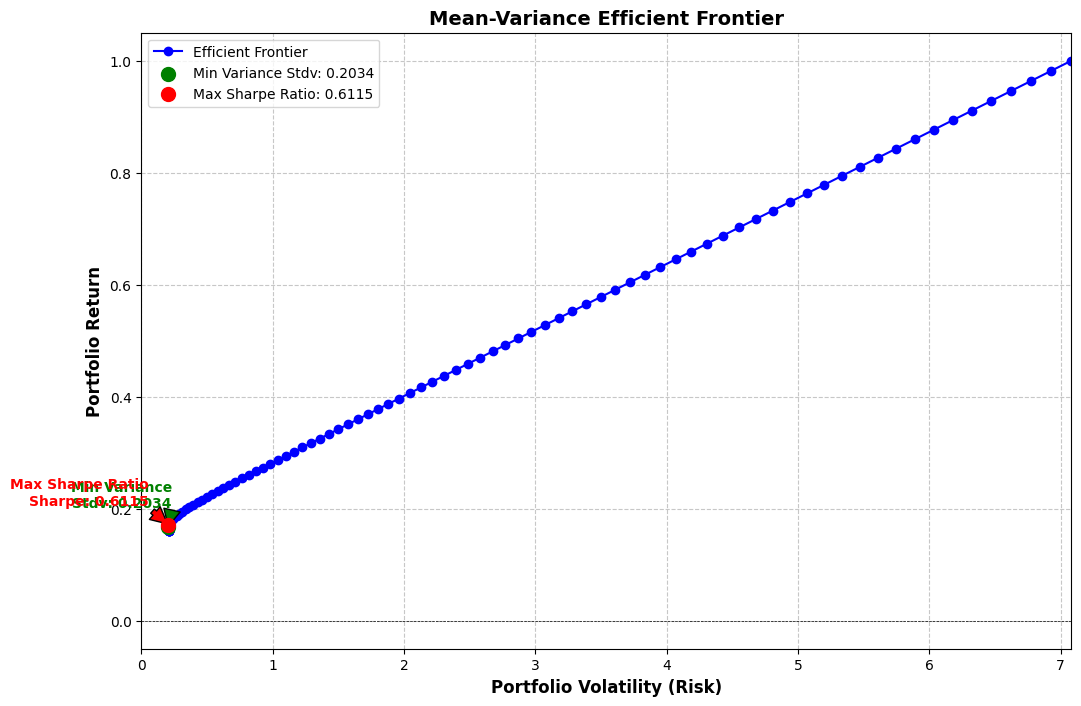




Maximum Sharpe Ratio Portfolio:
Return: 0.1714, Volatility: 0.2067, Sharpe Ratio: 0.6115



Maximum Utility Portfolio:
Return: 0.1714, Volatility: 0.2067, Utility: 0.1073



Minimum Volatility Portfolio:
Return: 0.1671, Volatility: 0.2034





In [4]:

main()